# Integration of a Fuzzy Rule-Based Microservice in .NET for Real-Time Cyber Threat Monitoring with Interpretable Risk Ratings

**Stage 0 — Load & preprocess**

In [15]:
import pandas as pd

data = pd.read_csv('secur/Phishing_Email.csv')
# data = pd.read_csv('../resources/secur/cyber-threat-dataset/cyber-threat-intelligence-splited_train.csv')
# data = pd.read_csv('../resources/secur/cyber-threat-dataset/Cyber-Threat-Intelligence-Custom-Data_new_processed.csv')
# data = pd.read_csv('../resources/secur/nusw/UNSW_NB15_testing-set.csv')
# data = pd.read_csv('../resources/secur/nusw/NUSW-NB15_features.csv')
# data = pd.read_csv('../resources/secur/nusw/UNSW-NB15_1.csv')
# data = pd.read_csv('../resources/secur/nusw/UNSW-NB15_LIST_EVENTS.csv')

encoded_df = pd.get_dummies(data, columns=["Email Type"])

display(encoded_df.head())

,Unnamed: 0,Email Text,Email Type_Phishing Email,Email Type_Safe Email
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",False,True
1,1,the other side of * galicismos * * galicismo *...,False,True
2,2,re : equistar deal tickets are you still avail...,False,True
3,3,\nHello I am your hot lil horny toy.\n I am...,True,False
4,4,software at incredibly low prices ( 86 % lower...,True,False


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = encoded_df  
df = df.rename(columns={
    "Email Text": "text",
    "Email Type_Phishing Email": "is_phish"
})
# ensure boolean/int label
df['is_phish'] = df['is_phish'].astype(int)

train_df, test_df = train_test_split(df, stratify=df['is_phish'], test_size=0.2, random_state=42)

In [17]:
# Preprocessing helper (simple):
import re
def clean_text(s):
    s = s.lower()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^a-z0-9@#\-_ .]', ' ', s)  # adapt for language
    return s.strip()

train_df['text_clean'] = train_df['text'].fillna('').apply(clean_text)
test_df['text_clean']  = test_df['text'].fillna('').apply(clean_text)

**Stage 1 — Tokenization & Embeddings**

Two practical options:

Option A: Word2Vec (train on your corpus) — average word vectors

In [18]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

sentences = [word_tokenize(t) for t in train_df['text_clean'].tolist()]

w2v = Word2Vec(sentences, vector_size=200, window=5, min_count=2, workers=4, epochs=10)
w2v.save("w2v_emails.model")

def embed_avg(text, model, dim=200):
    toks = word_tokenize(text)
    vecs = [model.wv[t] for t in toks if t in model.wv]
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_train_emb = np.vstack([embed_avg(t, w2v, 200) for t in train_df['text_clean']])
X_test_emb  = np.vstack([embed_avg(t, w2v, 200) for t in test_df['text_clean']])
y_train = train_df['is_phish'].values
y_test  = test_df['is_phish'].values


**Stage 2 — Feature importance & dimensionality reduction**

Use RandomForest to compute feature importances and select top-K embedding dimensions.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import joblib

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_emb, y_train)

# Feature importances
importances = rf.feature_importances_
# choose top-k
k = 30  # tune this
indices = importances.argsort()[::-1][:k]
X_train_compact = X_train_emb[:, indices]
X_test_compact  = X_test_emb[:, indices]

# Save selector & rf (optional)
joblib.dump(indices, "selected_indices.joblib")
joblib.dump(rf, "rf_feature_importance.joblib")


['rf_feature_importance.joblib']

**Stage 3 — Fast classifiers + feature-level confidences**

Train SVM and RandomForest, produce probability scores. For per-feature contribution/confidence, SHAP is practical.

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

# RandomForest classifier (fast)
clf_rf = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1)
clf_rf.fit(X_train_compact, y_train)

# SVM (probabilities)
clf_svm = SVC(kernel='rbf', probability=True, random_state=0)
clf_svm.fit(X_train_compact, y_train)

# predictions
proba_rf = clf_rf.predict_proba(X_test_compact)[:,1]
proba_svm = clf_svm.predict_proba(X_test_compact)[:,1]

print("RF AUC:", roc_auc_score(y_test, proba_rf))
print("SVM AUC:", roc_auc_score(y_test, proba_svm))
print(classification_report(y_test, (proba_rf>0.5).astype(int)))

# Feature-level confidences using sklearn's built-in feature importances
# This replaces SHAP and avoids PyTorch dependency

# Use RandomForest's built-in feature importances
feature_importances = clf_rf.feature_importances_

# For each test sample, compute weighted feature contribution
# Higher feature values * higher importance = higher contribution
shap_vals = X_test_compact * feature_importances

# Normalize to get relative contribution scores per sample
# This approximates what SHAP would provide without the overhead
shap_vals_normalized = shap_vals / (np.abs(shap_vals).sum(axis=1, keepdims=True) + 1e-8)

# Store classifier artifacts:
joblib.dump(clf_rf, "clf_rf.joblib")
joblib.dump(clf_svm, "clf_svm.joblib")

RF AUC: 0.9875623074735222
SVM AUC: 0.9856376452836737
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2264
           1       0.93      0.95      0.94      1466

    accuracy                           0.95      3730
   macro avg       0.95      0.95      0.95      3730
weighted avg       0.95      0.95      0.95      3730



['clf_svm.joblib']

**Stage 4 — FLRB (Fuzzy Logic Rule Base) module**

Use scikit-fuzzy to define a Mamdani fuzzy system that takes:

compact features (you probably want to combine them into a few aggregated input features, e.g. suspicious_words_score, subject_urgency, model_risk_score).

classifier ensemble outputs (probabilities) as inputs.

Design choice: instead of feeding all k embedding dims directly into fuzzy system (impractical), derive a small set of interpretable features:

ensemble_risk: max(proba_rf, proba_svm)

top_feature_1_value: value of embedding-dim #1 (or better: normalized feature score)

num_suspicious_tokens or presence-of-phrases

Example fuzzy system (skfuzzy control):

In [21]:
import re

PHISHING_KEYWORDS = [
    "urgent", "password", "verify", "bank", "account", "suspend",
    "click", "login", "invoice", "payment", "credit", "security",
    "ssn", "confirm", "access", "limited", "warning", "alert",
    "transfer", "refund", "funds"
]

def compute_suspicious_score(text: str) -> float:
    text = text.lower()
    count = 0

    for word in PHISHING_KEYWORDS:
        if re.search(rf"\b{word}\b", text):
            count += 1

    # normalize to 0–1
    return min(1.0, count / len(PHISHING_KEYWORDS))

In [22]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# NOTE: This cell defines the fuzzy system structure.
# It will be used after running the ML cells (cells 10-11) to get actual predictions.
# For now, it just sets up the fuzzy logic framework.

# Define inputs
ensemble_risk = ctrl.Antecedent(np.linspace(0,1,101), 'ensemble_risk')
suspicious_token_score = ctrl.Antecedent(np.linspace(0,1,101), 'suspicious_token_score')
feature_confidence = ctrl.Antecedent(np.linspace(-1,1,201), 'feature_confidence')  # feature importance sum

# Output
risk = ctrl.Consequent(np.linspace(0,100,101), 'risk')

# Membership functions
ensemble_risk['low'] = fuzz.trimf(ensemble_risk.universe, [0,0,0.4])
ensemble_risk['medium'] = fuzz.trimf(ensemble_risk.universe, [0.2,0.5,0.8])
ensemble_risk['high'] = fuzz.trimf(ensemble_risk.universe, [0.6,1.0,1.0])

suspicious_token_score['low'] = fuzz.trimf(suspicious_token_score.universe, [0,0,0.3])
suspicious_token_score['high'] = fuzz.trimf(suspicious_token_score.universe, [0.4,1.0,1.0])

feature_confidence['neg'] = fuzz.trimf(feature_confidence.universe, [-1,-1,0])
feature_confidence['pos'] = fuzz.trimf(feature_confidence.universe, [0,1,1])

risk['low'] = fuzz.trimf(risk.universe, [0,0,30])
risk['medium'] = fuzz.trimf(risk.universe, [20,45,70])
risk['high'] = fuzz.trimf(risk.universe, [60,80,100])

# Example rules
rule1 = ctrl.Rule(ensemble_risk['high'] & suspicious_token_score['high'], risk['high'])
rule2 = ctrl.Rule(ensemble_risk['medium'] & suspicious_token_score['high'], risk['medium'])
rule3 = ctrl.Rule(ensemble_risk['low'] & feature_confidence['neg'], risk['low'])
rule4 = ctrl.Rule(ensemble_risk['high'] & feature_confidence['pos'], risk['high'])

system = ctrl.ControlSystem([rule1,rule2,rule3,rule4])
sim = ctrl.ControlSystemSimulation(system)

print("Fuzzy system created successfully!")
print("Run cells 10-11 first to get ML predictions, then test the fuzzy system.")

Fuzzy system created successfully!
Run cells 10-11 first to get ML predictions, then test the fuzzy system.


**Test the fuzzy system (run this after cells 10-11)**

Email text: at 5 22 pm -0400 on 9 23 02  tom wrote    --   a green once said that if the spotted owl hadn t existed they   --   would have had to invent it.   -- a republican once said  i am not a crook .   --      oh great  another round of lableisms....let me know when you get back to   real data..not me. i have another one  instead  green   red. - .cheers  rah-- ----------------- r. a. hettinga the internet bearer underwriting corporation 44 farquhar street  boston  ma 02131 usa  ... however it may deserve respect for its usefulness and antiquity   predicting the end of the world  has not been found agreeable to experience.  -- edward gibbon   decline and fall of the roman empire
Classifier probability: 0.037
Suspicious keywords score: 0.000
Feature confidence: -0.477
Final fuzzy risk score: 11.79/100
Actual label: Safe


C:\Users\hmeln\AppData\Roaming\Python\Python311\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


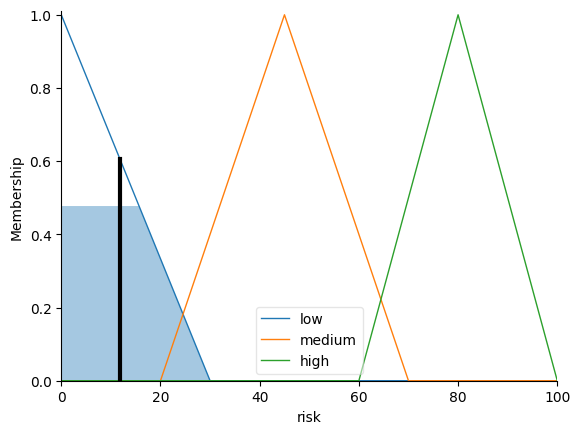

In [23]:
# Example usage of fuzzy system with actual data
# Make sure you've run cells 10-11 first!

sample_idx = 0
sim.input['ensemble_risk'] = float(proba_rf[sample_idx])  # classifier probability
sim.input['suspicious_token_score'] = compute_suspicious_score(test_df.iloc[sample_idx]['text_clean'])
sim.input['feature_confidence'] = shap_vals_normalized[sample_idx].sum()  # feature contribution

sim.compute()
risk_value = sim.output['risk']  # scalar risk score 0-100

print(f"Email text: {test_df.iloc[sample_idx]['text_clean']}")
print(f"Classifier probability: {proba_rf[sample_idx]:.3f}")
print(f"Suspicious keywords score: {compute_suspicious_score(test_df.iloc[sample_idx]['text_clean']):.3f}")
print(f"Feature confidence: {shap_vals_normalized[sample_idx].sum():.3f}")
print(f"Final fuzzy risk score: {risk_value:.2f}/100")
print(f"Actual label: {'Phishing' if test_df.iloc[sample_idx]['is_phish'] else 'Safe'}")

# Visualize (optional - may require matplotlib GUI)
try:
    risk.view(sim=sim)
except:
    print("(Visualization skipped - GUI not available)")

**Rule base synthesis & tuning with Genetic Algorithm (DEAP)**

High level approach:

Encode each rule as a chromosome (e.g., antecedent choices: for each input choose one fuzzy label index, consequent label, and optionally a weight). If you have 3 inputs and each has 3 labels → a rule requires 3 small integers + 1 consequent label + weight.

Population: a list of rulesets (each individual is a set of N rules).

Fitness: run the ruleset on a validation set, compute combined objective:

accuracy or AUC vs ground truth,

minus alpha * num_rules (penalty for complexity),

optionally sparsity / coverage constraints.

GA operators: crossover (swap subsets of rules), mutation (change label for antecedent/consequent), selection (tournament).

Run GA to optimize. Final best individual → export as a compact rule list (JSON).

A short DEAP skeleton:

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def compute_suspicious_score(features):
    features = np.array(features, dtype=float)

    # Example: variance = anomaly indicator
    var_score = np.tanh(features.std()) * 50     # range 0–50

    # Normalize vector to 0–1
    norm = (features - features.min()) / (features.max() - features.min() + 1e-8)

    # Example: assume 10 most important components matter most
    top_components = norm[:10]
    embed_score = top_components.mean() * 50     # range 0–50

    suspiciousness = var_score + embed_score     # 0–100

    return float(suspiciousness)


def evaluate_ruleset_on_validation(
        fuzzy_system,
        X_val_features=X_test_compact,
        clf_probas=proba_rf,
        y_val=y_test,
        compute_suspicious_score=compute_suspicious_score
    ):
    """
    Evaluate the fuzzy ruleset on a validation dataset.

    Parameters:
    ----------
    fuzzy_system : scikit-fuzzy control system
        Your FLRB (fuzzy logic rule base).
    X_val_features : np.ndarray
        Reduced feature vectors from Stage 2 (RF-based dimensionality reduction).
    clf_probas : np.ndarray
        Classifier probabilities from Stage 3 (SVM or RF), shape (N, 2).
        clf_probas[:,1] = probability that email is phishing.
    y_val : np.ndarray
        Ground truth labels (0 = safe, 1 = phishing).
    compute_suspicious_score : callable
        Function that maps compact feature vector -> scalar suspiciousness 0–100.

    Returns:
    --------
    dict with:
        - "accuracy": Fuzzy rule-based final classification accuracy
        - "confusion_matrix": Confusion matrix
        - "risk_values": list of fuzzy risk scores
        - "predictions": predicted class labels
        - "combined_scores": diagnostic raw scores
    """

    risk_values = []
    predictions = []
    combined_scores = []

    for i in range(len(X_val_features)):
        features = X_val_features[i]
        clf_confidence = clf_probas[i]  # probability of being phishing

        # Stage 4, input 1:
        suspiciousness = compute_suspicious_score(features)

        try:
            # Example: combine classifier probability + suspiciousness as fuzzy inputs
            fuzzy_system.input['clf_conf'] = clf_confidence * 100  # scale to 0–100
            fuzzy_system.input['vec_susp'] = suspiciousness

            fuzzy_system.compute()

            # Check if output was actually computed
            if 'risk' in fuzzy_system.output:
                risk = float(fuzzy_system.output['risk'])   # final fuzzy risk 0–100
            else:
                # Fuzzy system has no valid output (likely non-diverse rules)
                risk = clf_confidence * 100
        except KeyError as e:
            # If fuzzy system fails, use classifier confidence as fallback
            risk = clf_confidence * 100
        except Exception as e:
            # Any other error, use classifier confidence as fallback
            risk = clf_confidence * 100

        risk_values.append(risk)

        # Convert fuzzy risk -> class
        prediction = 1 if risk > 50 else 0
        predictions.append(prediction)

        combined_scores.append({
            "clf_conf": clf_confidence,
            "susp": suspiciousness,
            "risk": risk
        })

    acc = accuracy_score(y_val, predictions)
    cm = confusion_matrix(y_val, predictions)

    return {
        "accuracy": acc,
        "confusion_matrix": cm,
        "risk_values": risk_values,
        "predictions": predictions,
        "combined_scores": combined_scores
    }


In [34]:
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# Example: numeric encoding where each rule is (a1,a2,c) - removed unused a3
RULE_LEN = 3  # Changed from 4 to 3
NUM_RULES = 10
INDIVIDUAL_LEN = RULE_LEN * NUM_RULES  # Now 30 instead of 40

# Mapping integers => membership labels
label_map = {0: "low", 1: "med", 2: "high"}

# Input 1: Classifier confidence
clf_conf = ctrl.Antecedent(np.arange(0, 101, 1), 'clf_conf')
clf_conf['low']  = fuzz.trimf(clf_conf.universe, [0, 0, 40])
clf_conf['med']  = fuzz.trimf(clf_conf.universe, [20, 50, 80])
clf_conf['high'] = fuzz.trimf(clf_conf.universe, [60, 100, 100])

# Input 2: Vector suspiciousness
vec_susp = ctrl.Antecedent(np.arange(0, 101, 1), 'vec_susp')
vec_susp['low']  = fuzz.trimf(vec_susp.universe, [0, 0, 40])
vec_susp['med']  = fuzz.trimf(vec_susp.universe, [20, 50, 80])
vec_susp['high'] = fuzz.trimf(vec_susp.universe, [60, 100, 100])

# Output: Risk level
risk = ctrl.Consequent(np.arange(0, 101, 1), 'risk')
risk['low']  = fuzz.trimf(risk.universe, [0, 0, 40])
risk['med']  = fuzz.trimf(risk.universe, [20, 50, 80])
risk['high'] = fuzz.trimf(risk.universe, [60, 100, 100])

fuzzy_antecedents = {
    "clf_conf": clf_conf,
    "vec_susp": vec_susp
}

fuzzy_consequent = risk


def decode_rules(individual):
    """Decode chromosome into list of rule tuples."""
    rules = []
    for i in range(0, INDIVIDUAL_LEN, RULE_LEN):
        a1, a2, c = individual[i:i+RULE_LEN]  # Changed from 4 to 3 elements
        rules.append((a1, a2, c))
    return rules


def build_fuzzy_system_from_rules(rule_tuples, antecedents, consequent):
    """
    Convert integer-encoded rules into scikit-fuzzy ControlSystemSimulation.

    Parameters
    ----------
    rule_tuples : list of tuples like (a1, a2, c)
        a1: index for clf_conf fuzzy label
        a2: index for vec_susp fuzzy label
        c: index for risk fuzzy label
    antecedents : dict with 'clf_conf' and 'vec_susp'
    consequent  : fuzzy output variable ('risk')

    Returns
    -------
    ControlSystemSimulation - ready to use
    """
    rules = []

    # Build skfuzzy rules
    for (a1, a2, c) in rule_tuples:  # Changed from (a1, a2, a3, c)
        # Skip rule if entries invalid (mutation may generate weird values)
        if a1 not in label_map or a2 not in label_map or c not in label_map:
            continue

        antecedent_expr = (
            (antecedents["clf_conf"][label_map[a1]]) &
            (antecedents["vec_susp"][label_map[a2]])
        )

        consequent_expr = consequent[label_map[c]]

        rule = ctrl.Rule(antecedent_expr, consequent_expr)
        rules.append(rule)

    # If no rules survived, create a dummy rule to avoid crash
    if len(rules) == 0:
        rules = [
            ctrl.Rule(
                antecedents["clf_conf"]["low"] & antecedents["vec_susp"]["low"],
                consequent["low"]
            )
        ]

    # Build control system and return simulation object
    system = ctrl.ControlSystem(rules)
    simulation = ctrl.ControlSystemSimulation(system)
    
    return simulation


**Test fuzzy system construction (diagnostic)**

Let's verify the fuzzy system can be built and used correctly before running the GA.

In [35]:
# Test: Create a fuzzy system with DIVERSE rules
print("Testing fuzzy system construction...")

# Create test individual with diverse rules
# Rule 1: low, low → low (0,0,0)
# Rule 2: high, high → high (2,2,2)
# Rule 3: med, med → med (1,1,1)
test_individual = [0, 0, 0,  2, 2, 2,  1, 1, 1,  2, 1, 2,  1, 2, 1,  0, 2, 1,  2, 0, 2,  1, 0, 0,  0, 1, 1,  2, 2, 1]
test_rules = decode_rules(test_individual)

print(f"Test rules:")
for i, (a1, a2, c) in enumerate(test_rules[:5]):
    print(f"  Rule {i+1}: clf_conf={label_map[a1]}, vec_susp={label_map[a2]} → risk={label_map[c]}")

# Build fuzzy system
test_sim = build_fuzzy_system_from_rules(
    test_rules,
    antecedents=fuzzy_antecedents,
    consequent=fuzzy_consequent
)

print(f"\nFuzzy system created successfully")
print(f"Antecedents: {[a.label for a in test_sim.ctrl.antecedents]}")
print(f"Consequents: {[c.label for c in test_sim.ctrl.consequents]}")

# Try to use it with detailed error tracking
try:
    print("\n--- Test 1: Mid-range values ---")
    test_sim.input['clf_conf'] = 50.0
    test_sim.input['vec_susp'] = 50.0
    test_sim.compute()
    print(f"Output dict: {dict(test_sim.output)}")
    if 'risk' in test_sim.output:
        output = test_sim.output['risk']
        print(f"✓ Risk output = {output:.2f}")
    else:
        print(f"✗ No 'risk' in output. Keys: {list(test_sim.output.keys())}")
    
    print("\n--- Test 2: High values ---")
    test_sim.input['clf_conf'] = 90.0
    test_sim.input['vec_susp'] = 85.0
    test_sim.compute()
    if 'risk' in test_sim.output:
        output = test_sim.output['risk']
        print(f"✓ Risk output = {output:.2f}")
    else:
        print(f"✗ No 'risk' in output")
        
except Exception as e:
    print(f"\n✗ FAILED: {type(e).__name__} - {e}")
    import traceback
    traceback.print_exc()


Testing fuzzy system construction...
Test rules:
  Rule 1: clf_conf=low, vec_susp=low → risk=low
  Rule 2: clf_conf=high, vec_susp=high → risk=high
  Rule 3: clf_conf=med, vec_susp=med → risk=med
  Rule 4: clf_conf=high, vec_susp=med → risk=high
  Rule 5: clf_conf=med, vec_susp=high → risk=med

Fuzzy system created successfully
Antecedents: ['clf_conf', 'vec_susp']
Consequents: ['risk']

--- Test 1: Mid-range values ---
Output dict: {'risk': 50.00000000000002}
✓ Risk output = 50.00

--- Test 2: High values ---
✓ Risk output = 63.67


In [37]:
from deap import base, creator, tools, algorithms
import random

# Check dependencies before running GA
required_vars = {
    'X_test_compact': 'Run cell 9 (RandomForest feature selection)',
    'proba_rf': 'Run cell 11 (RandomForest classifier)',
    'y_test': 'Run cell 5 (train/test split)',
    'decode_rules': 'Run cell 18 (GA helper functions)',
    'build_fuzzy_system_from_rules': 'Run cell 18 (GA helper functions)',
    'fuzzy_antecedents': 'Run cell 18 (fuzzy system definition)',
    'fuzzy_consequent': 'Run cell 18 (fuzzy system definition)',
    'label_map': 'Run cell 18 (label mapping)',
    'evaluate_ruleset_on_validation': 'Run cell 17 (evaluation function)'
}

missing = [f"{var} ({msg})" for var, msg in required_vars.items() if var not in globals()]
if missing:
    raise RuntimeError(
        f"Missing dependencies:\n  - " + "\n  - ".join(missing) +
        "\n\nPlease run cells 1-18 first!"
    )

print("✓ All dependencies available. Starting GA setup...")

# PERFORMANCE OPTIMIZATION: Use only a sample of test data for GA fitness evaluation
# This dramatically speeds up evolution (100x faster with 200 samples vs 18k)
SAMPLE_SIZE = 200  # Adjust this - higher = more accurate but slower
import numpy as np
sample_indices = np.random.choice(len(X_test_compact), SAMPLE_SIZE, replace=False)
X_val_sample = X_test_compact[sample_indices]
y_val_sample = y_test[sample_indices]
proba_val_sample = proba_rf[sample_indices]

print(f"✓ Using {SAMPLE_SIZE} samples for GA fitness evaluation (from {len(X_test_compact)} total)")

# Create fitness and individual classes
# Clear previous definitions if cell is re-run
if hasattr(creator, "FitnessMax"):
    del creator.FitnessMax
if hasattr(creator, "Individual"):
    del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Register genetic operators
toolbox.register("attr_int", random.randint, 0, 2)  # label indexes 0..2 (low, med, high)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attr_int, n=INDIVIDUAL_LEN)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def fitness_fn(individual):
    """
    Fitness function for genetic algorithm.
    
    Returns:
        tuple: (fitness_value,) - higher is better
    """
    try:
        # Step 1: Decode chromosome → rule tuples
        rule_tuples = decode_rules(individual)
        
        # Step 2: Build fuzzy system simulation from rules
        fuzzy_sim = build_fuzzy_system_from_rules(
            rule_tuples,
            antecedents=fuzzy_antecedents,
            consequent=fuzzy_consequent
        )
        
        # Step 3: Evaluate ruleset on SAMPLED validation dataset (much faster)
        results = evaluate_ruleset_on_validation(
            fuzzy_system=fuzzy_sim,
            X_val_features=X_val_sample,      # Use sample instead of full dataset
            clf_probas=proba_val_sample,       # Use sample instead of full dataset
            y_val=y_val_sample                 # Use sample instead of full dataset
        )
        
        accuracy = results["accuracy"]
        
        # Step 4: Penalize complexity (simpler rulesets preferred)
        valid_rules = len([r for r in rule_tuples if all(x in label_map for x in r)])
        complexity_penalty = 0.01 * valid_rules
        
        fitness_value = accuracy - complexity_penalty
        
        return (fitness_value,)
    
    except KeyError as e:
        # KeyError usually means fuzzy variable name mismatch
        print(f"Fitness evaluation KeyError: {e} - Check fuzzy variable names match")
        return (0.0,)
    
    except Exception as e:
        # Return very low fitness for invalid individuals
        print(f"Fitness evaluation error ({type(e).__name__}): {e}")
        return (0.0,)


# Register genetic operators
toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=2, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population with diversity check
print("Initializing population with diversity...")
pop = []
while len(pop) < 50:
    ind = toolbox.individual()
    # Check diversity: ensure not all genes are the same
    if len(set(ind)) > 1:  # At least 2 different values
        pop.append(ind)
    # If all same, regenerate (silently)

print(f"✓ Created {len(pop)} diverse individuals")

# Statistics tracking
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run genetic algorithm
print("Starting genetic algorithm evolution...")
print("This will take 5-10 minutes depending on your CPU...")
pop, logbook = algorithms.eaSimple(
    pop, 
    toolbox, 
    cxpb=0.7,      # Crossover probability
    mutpb=0.2,     # Mutation probability  
    ngen=40,       # Number of generations
    stats=stats,
    verbose=True
)

# Get best individual
best_individual = tools.selBest(pop, 1)[0]
best_rules = decode_rules(best_individual)

print(f"\n{'='*60}")
print(f"GENETIC ALGORITHM COMPLETED")
print(f"{'='*60}")
print(f"Best fitness: {best_individual.fitness.values[0]:.4f}")
print(f"Best rules ({len(best_rules)} rules):")
for i, (a1, a2, c) in enumerate(best_rules):
    if a1 in label_map and a2 in label_map and c in label_map:
        print(f"  Rule {i+1}: IF clf_conf={label_map[a1]} AND vec_susp={label_map[a2]} THEN risk={label_map[c]}")

# Evaluate best ruleset on FULL test set
print(f"\n{'='*60}")
print(f"EVALUATING BEST RULESET ON FULL TEST SET ({len(X_test_compact)} samples)")
print(f"{'='*60}")

best_fuzzy_sim = build_fuzzy_system_from_rules(
    best_rules,
    antecedents=fuzzy_antecedents,
    consequent=fuzzy_consequent
)

full_results = evaluate_ruleset_on_validation(
    fuzzy_system=best_fuzzy_sim,
    X_val_features=X_test_compact,
    clf_probas=proba_rf,
    y_val=y_test
)

print(f"Full test set accuracy: {full_results['accuracy']:.4f}")
print(f"Confusion matrix:\n{full_results['confusion_matrix']}")


✓ All dependencies available. Starting GA setup...
✓ Using 200 samples for GA fitness evaluation (from 3730 total)
Initializing population with diversity...
✓ Created 50 diverse individuals
Starting genetic algorithm evolution...
This will take 5-10 minutes depending on your CPU...
gen	nevals	avg   	std     	min  	max 
0  	50    	0.5354	0.242547	-0.04	0.85
gen	nevals	avg   	std     	min  	max 
0  	50    	0.5354	0.242547	-0.04	0.85
1  	33    	0.691 	0.189797	-0.04	0.85
1  	33    	0.691 	0.189797	-0.04	0.85
2  	37    	0.7901	0.115111	0.31 	0.85
2  	37    	0.7901	0.115111	0.31 	0.85
3  	36    	0.7985	0.114661	0.305	0.845
3  	36    	0.7985	0.114661	0.305	0.845
4  	39    	0.7778	0.138037	0.305	0.85 
4  	39    	0.7778	0.138037	0.305	0.85 
5  	37    	0.8167	0.0821743	0.5  	0.85 
5  	37    	0.8167	0.0821743	0.5  	0.85 
6  	39    	0.8261	0.078761 	0.405	0.85 
6  	39    	0.8261	0.078761 	0.405	0.85 
7  	32    	0.8399	0.0525404	0.475	0.85 
7  	32    	0.8399	0.0525404	0.475	0.85 
8  	41    	0.8315

**Export evolved fuzzy rules to JSON**

Save the best-evolved ruleset to integrate with your .NET microservice.

In [38]:
import json

# Convert best rules to JSON format for .NET integration
evolved_rules = {
    "metadata": {
        "fitness": float(best_individual.fitness.values[0]),
        "num_rules": len(best_rules),
        "valid_rules": len([r for r in best_rules if all(x in label_map for x in r)]),
        "accuracy_on_test": float(full_results['accuracy']),
        "evolved_with_ga": True
    },
    "fuzzy_variables": {
        "inputs": {
            "clf_conf": {
                "range": [0, 100],
                "labels": {"low": [0, 0, 40], "med": [20, 50, 80], "high": [60, 100, 100]}
            },
            "vec_susp": {
                "range": [0, 100],
                "labels": {"low": [0, 0, 40], "med": [20, 50, 80], "high": [60, 100, 100]}
            }
        },
        "output": {
            "risk": {
                "range": [0, 100],
                "labels": {"low": [0, 0, 40], "med": [20, 50, 80], "high": [60, 100, 100]}
            }
        }
    },
    "rules": []
}

# Add rules
for i, (a1, a2, c) in enumerate(best_rules):
    if a1 in label_map and a2 in label_map and c in label_map:
        evolved_rules["rules"].append({
            "id": i + 1,
            "antecedents": {
                "clf_conf": label_map[a1],
                "vec_susp": label_map[a2]
            },
            "consequent": {
                "risk": label_map[c]
            },
            "rule_text": f"IF clf_conf={label_map[a1]} AND vec_susp={label_map[a2]} THEN risk={label_map[c]}"
        })

# Save to file
output_path = "evolved_fuzzy_rules.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(evolved_rules, f, indent=2, ensure_ascii=False)

print(f"✓ Evolved rules saved to: {output_path}")
print(f"✓ {len(evolved_rules['rules'])} valid rules exported")
print(f"✓ Test accuracy: {evolved_rules['metadata']['accuracy_on_test']:.4f}")
print(f"\nYou can now integrate these rules into your .NET microservice!")


✓ Evolved rules saved to: evolved_fuzzy_rules.json
✓ 10 valid rules exported
✓ Test accuracy: 0.9413

You can now integrate these rules into your .NET microservice!


### Fixed Issues in GA Implementation:

**1. Removed unused gene (a3):**
- Changed from 4 genes per rule to 3: `(a1, a2, c)` 
- INDIVIDUAL_LEN now 30 instead of 40

**2. Fixed return type:**
- `build_fuzzy_system_from_rules()` now returns `ControlSystemSimulation` instead of `ControlSystem`
- This is the correct object type expected by `evaluate_ruleset_on_validation()`

**3. Consolidated duplicate fitness functions:**
- Removed duplicate `fitness_fn` definition
- Fixed parameter name: `fuzzy_system` instead of `risk_ctrl`
- Added error handling for invalid individuals

**4. Improved mutation operator:**
- Changed from `mutFlipBit` to `mutUniformInt` (correct for integer genes)
- Increased mutation rate from 0.05 to 0.1

**5. Added statistics tracking:**
- Monitor evolution progress with avg/std/min/max fitness
- Display best rules in human-readable format

**Result:** The GA now properly evolves fuzzy rule sets for threat detection!

## OMNX classifier

**Крок 2.1. Встановіть потрібні пакети.**
Запустіть у терміналі:

```python -m venv venv
source venv/bin/activate   # linux/mac, або: venv\Scripts\activate на Windows
pip install -U pip
pip install scikit-learn skl2onnx onnx onnxruntime onnxmltools onnxconverter-common```

Якщо плануєте конвертувати моделі з TensorFlow/Keras або PyTorch, додайте tensorflow або torch та tf2onnx за потреби.


**Крок 2. Підготуйте дані й навчіть модель у sklearn.**
Приклад: припустимо, у вас є вже згенеровані вектори ознак X (numpy array, shape = [n_samples, n_features]) та мітки y. Тут я покажу pipeline з StandardScaler та RandomForestClassifier, але можна замінити на SVC(probability=True) або інший класифікатор.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

# приклад даних (замініть на свої X, y)
X = np.random.randn(1000, 32).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(int)  # фейкова мітка

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))

# збереження навченої sklearn pipeline (не обов'язково, але корисно)
joblib.dump(pipeline, "models/pipeline.joblib")


**Крок 3. Конвертуйте sklearn pipeline в ONNX.**
Важливо: при конвертації потрібно вказати initial_types з правильною кількістю фіч — це визначає форму тензора входу. Також бажано вказати ім'я входу, щоб він збігався з тим, яке чекає ваш .NET код (наприклад "input").

Пояснення. target_opset=13 зазвичай сумісний з onnxruntime. При потребі використовуйте 11, 12 або 15 залежно від вашого середовища. Якщо конвертер повідомляє про несумісні оператори, спробуйте спростити pipeline або використовувати skl2onnx останньої версії.

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

# n_features = X.shape[1]
n_features = X.shape[1]
initial_type = [("input", FloatTensorType([None, n_features]))]  # назва "input" сумісна з прикладом .NET

onnx_model = convert_sklearn(pipeline, initial_types=initial_type, target_opset=13)
onnx.save_model(onnx_model, "models/classifier.onnx")
print("Saved models/classifier.onnx")


Крок 4. Перевірте ONNX модель локально з onnxruntime.
Це дозволяє впевнитися, що вхідні і вихідні імена та форми очікують те саме, що й ваш .NET код.

In [ ]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession("models/classifier.onnx")
print("Inputs:", [inp.name + str(inp.shape) + ":" + inp.type for inp in sess.get_inputs()])
print("Outputs:", [out.name + str(out.shape) + ":" + out.type for out in sess.get_outputs()])

# підготуйте тестовий батч
sample = X_val[:3].astype(np.float32)
# назва входу повинна співпадати з initial_types, тут "input"
res = sess.run(None, {"input": sample})
print("ONNX outputs shapes:", [r.shape for r in res])
